# De-Reverberation Initial Investigation

### Setup and Installations

In [1]:
%matplotlib inline

### Scratchpad

### Imports

In [67]:
#%%writefile imports.py

# Pytorch Stuff
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
import torch.nn as nn
import torch.nn.functional as F
import torchaudio as ta
import torchaudio.functional as taf

# Librosa for audio stuff/plotting spectrograms
import numpy as np
import librosa as lr
from librosa.display import *


# Plotting
import matplotlib.pyplot as plt
import matplotlib
matplotlib.rcParams['figure.figsize'] = [10, 8]

# Utilities
from IPython.display import Audio
from tqdm import tqdm_notebook as tqdm # progress bars
import random
from pathlib import Path
Path.ls = lambda x: list(x.iterdir())

import pandas as pd
import ast

### Convenience Functions

In [68]:
#%%writefile utils.py
#from imports import *

# Shorthand amplitude->db conversion
db = lambda x: lr.amplitude_to_db(x)

def plot_spec(sig,sr=22050, channel=None):
    """
    Plots spectrogram of time domain signal (numpy or tensor) with default parameters.
    channel: selects one channel if input has multiple channels
    """
    if type(sig) is torch.Tensor:
        sig = sig.squeeze().numpy()
    if channel != None:
        sig = sig[:,channel].squeeze()
    spec = db(abs(lr.stft(sig))) 
    return specshow(spec, x_axis='time', y_axis='mel', sr=sr)
    
    
def cola_window(win_size, hop_len, win_type=np.hamming):
    """
    Creates a window for which the COLA constraint holds
    """
    w = win_type(win_size)
    w = np.sqrt(w)
    K = np.sqrt(hop_len / sum(pow(w,2)))
    w = w * K
    return w

def fourier(x):
    """
    Converts a time domain tensor to frequency domain and takes angle/phase form
    """
    return taf.magphase(x.rfft(1))

def polar_to_cart(x):
    """
    Converts a tensor with last dimension in [angle, phase] to [a, jb] form
    """
    amp = x[:,0].unsqueeze(-1)
    phase = x[:,1].unsqueeze(-1)
    return torch.cat((amp*torch.cos(phase), amp*torch.sin(phase)), dim=-1)

def db_to_amp(x):
    """
    Converts a pytorch tensor from decibels to amplitude
    """
    return torch.pow(10, (0.5*x))

def amp_to_db(x):
    """
    Converts a pytorch tensor amplitude to decibels
    """
    return taf.amplitude_to_DB(x, 20, -80, 0)

### 

In [69]:
#%%writefile AudioTransforms.py
#from imports import *

class Noise(object):
    """ Adds a random noise file to the original signal at a random normally distributed amplitude
    """
    def __init__(self, noise_path, noise_sr=None, db_mean=-12, db_sd=3, use_cuda=False):
        """
        Args:
            noise_path (str|Path): path to noise files, or list of files
            noise_sr (int): rate at which to resample noise files. If None, uses native sample rate.
            db_mean (float|int): mean amplitude of noise w.r.t. speech signal in decibels (default: -12)
            db_sd (float|int): standard deviation of noise amplitude in decibels (default: 3)
        """
        if type(noise_path) is not list:
            noise_path = list(noise_path.glob('*.wav'))
            
        self.noises, self.srs = zip(*[ta.load(x) for x in tqdm(noise_path, desc='Loading Noises...')])
        
        if use_cuda:
            self.noises = [x.cuda() for x in self.noises]
            
        if noise_sr:
            self.noises = [ta.transforms.Resample(self.srs[i], noise_sr)(self.noises[i]) for i in 
                           tqdm(range(len(self.noises)), desc='Resampling Noises...')]
            
        self.db_dist = (db_mean, db_sd)
        
    def __call__(self, speech):
        db = np.random.normal(self.db_dist[0], self.db_dist[1])
        amp = lr.db_to_amplitude(db)
        n = random.choice(self.noises)
        if speech.shape[-1] < n.shape[-1]:
            return speech + amp * n[:,:speech.shape[-1]]
        else:
            return speech[:,:n.shape[-1]] + amp * n

class Reverb(object):
    """ Adds a convolutional reverb to the speech from a randomly chosen impulse response
        Crops the beginning of the impulse response to non-silent parts to maintain time-alignment of input and target
    """
    def __init__(self, ir_path, ir_sr=None, ir_mono=True, use_cuda=False):
        """
        Args:
            ir_path (str|Path): path to a directory of impulse responses or list of files
            ir_sr (int): rate at which to resample impulse responses. if None (default) uses native sample rate.
            ir_mono (bool): if true, loads only first channel of impulse response, else loads all channels
        """
        if type(ir_path) is not list:
            ir_path = list(ir_path.glob('*.wav'))
            
        self.irs, self.srs = zip(*[ta.load(x) for x in tqdm(ir_path, desc='Loading Impulse Responses...')])
        
        if ir_sr:
            self.irs = [ta.transforms.Resample(self.srs[i], ir_sr)(self.irs[i]) for i in 
                        tqdm(range(len(self.irs)), desc='Resampling Impulse Responses...')]
        if ir_mono:
            self.irs = [x[0,:] for x in self.irs]
            
        if use_cuda:
            self.irs = [x.cuda() for x in self.irs]
            
        # Crop beginning silence of IRS
        crop_idxs = [x.argmax(-1) for x in self.irs]
        self.irs = [x[crop_idxs[i]:].unsqueeze(0).unsqueeze(1) for i,x in enumerate(self.irs)]
    
    def __call__(self, speech):
        ir = random.choice(self.irs)
        if ir.shape[-1] < speech.shape[-1]:
            padding = ir.shape[-1]
            inputs, filters = speech.unsqueeze(0), ir.flip(-1)
        else:
            padding = speech.shape[-1]
            inputs, filters = ir, speech.unsqueeze(0).flip(-1)
            
        return F.conv1d(inputs, filters, padding=padding)[0,:,:speech.shape[-1]].cpu()
        
        # TODO: replace this with torch.conv1d
        #return torch.Tensor(np.convolve(speech.squeeze().numpy(), ir.squeeze().numpy(), 'same')).unsqueeze(0)

class RandomCrop(object):
    """ Crop sample to fixed length starting at random position. Pads with zeros if sample not long enough.
    """
    def __init__(self, length, no_rand=False):
        """
        Args:
            length (int): length of returned clips in samples
            no_rand (bool): if true will always start at beginning of clip. (default: False)
        """
        self.crop_len = length
        self.no_rand = no_rand
        
    def __call__(self, speech):
        if self.no_rand:
            start = 0
        else:
            start = random.randint(0, abs(speech.shape[-1]-self.crop_len))
            
        if speech.shape[-1] > self.crop_len:
            return speech[:,start:start+self.crop_len]
        else:
            retval = torch.zeros((1,self.crop_len))
            retval[:,0:speech.shape[-1]] = speech
            return retval

class LoadCrop(object):
    """ Similar to RandomCrop, but acts on loading the signal to save disk bandwidth.
        About 20x faster in testing when using a frame length of 2048.
    """
    def __init__(self, length, no_rand=False):
        """
        Args:
            length (int): length of returned clips in samples
            no_rand (bool): if true will always start at beginning of clip. (default: False)
        """
        self.crop_len = length
        self.no_rand = no_rand
        
    def __call__(self, fn):
        si,_ = ta.info(str(fn))
        
        if self.no_rand:
            start = 0
        else:
            start = random.randint(0, abs(si.length-self.crop_len-1))
        
            
        try:
            if si.length > (self.crop_len + start):
                return ta.load(fn, num_frames=self.crop_len, offset=start)
        except Exception as E:
            print(E)
            pass
            
        # if problem happened above
        speech,ssr = ta.load(fn)
        if speech.shape[-1] < self.crop_len:
            retval = torch.zeros((1,self.crop_len))
            retval[:,0:speech.shape[-1]] = speech
            return (retval, ssr)
        else: # some other problem occurred reading a chunk of the file
            return (speech[:,:self.crop_len], ssr)
        
        
class Normalize(object):
    """ Normalizes a raw-audio waveform to the range specified
    """
    def __init__(self, max_abs_val=1, eps=1e-12):
        self.eps = eps
        self.max_abs_val = max_abs_val
        
    def __call__(self,x):
        return self.max_abs_val * (x / (torch.max(torch.abs(x)) + self.eps))

In [70]:
speech_sr = 16000

In [297]:
#%%writefile DeReverbDataset.py
#from imports import *

class FMADataset(Dataset):
    """
    Pytorch dataset for audio sequence to sequence tasks. 
    """
    def __init__(self, root_path, 
                 audio_path='fma_audio/', 
                 meta_path='fma_meta/',
                 genres=None,
                 loadcrop=None,
                 tfms=ta.transforms.MelSpectrogram(sample_rate=44100, n_fft=4096)):
        self.rp = Path(root_path)
        self.audio_files = list((self.rp/audio_path).glob("**/*.mp3"))
        self.labels = pd.read_csv(self.rp/meta_path/"raw_tracks.csv")
        self.labels.track_genres = self.fix_genres(self.labels.track_genres)
        self.gdf = pd.read_csv(self.rp/meta_path/"genres.csv")
        self.tfms = tfms
        
        self.tlgenres = {}
        for i,gid in enumerate(self.gdf.genre_id):
            self.topgs = []
            top = self.gdf['top_level'].iloc[i]
            if top not in self.topgs:
                self.topgs.append(top)
            self.tlgenres[gid] = {"name": self.gdf['title'].iloc[i], 
                                  "tlg": self.topgs.index(top)} 
            
        # Filter audio files
        self.audio_files = [x for x in self.audio_files if self.get_genre(x) is not None]
            
        if loadcrop:
            self.loader = loadcrop
        else:
            self.loader = ta.load
            
    def fix_genres(self, genre_string):
        """ Turns strings in genre dataframe into a single-genre dictionary
        """
        try:
            return ast.literal_eval(genre_string)[0]
        except:
            return None
        
    def get_genre(self, af, ngs=16):
        """ Utility function to get the genre as a one-hot tensor
        """
        try:
            g = int(tracks[tracks.track_id == int(af.parts[-1][:-4])].track_genres.iloc[0]['genre_id'])
            topg = self.tlgenres[g]["tlg"]
            assert topg < ngs, f"genre {topg} > number of possible genres {ngs}"
            return (self.tlgenres[g]["name"], F.one_hot(torch.tensor(topg), num_classes=ngs))
        except Exception as E:
            print(E)
            return None
    
    def show(self, idx):
        """ displays a spectrogram with track title and genre
        """
        it = self.__getitem__(idx)
        plt.imshow(torch.log10(it['audio'][0,:,:].detach().flip(0)))
        gname = it["genre"]
        title = self.labels.track_title[idx]
        artist = self.labels.artist_name[idx]
        plt.title(f"{gname}: {title} by {artist}")
        plt.show()
        display(Audio(self.audio_files[idx]))

    def __len__(self):
        return len(self.audio_files)
    
    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
        
        afn = self.audio_files[idx]
        audio, sr = self.loader(afn)
        
        if self.tfms:
            audio = self.tfms(audio).detach()
            
        # TODO: load label here
        name, label = self.get_genre(afn)
            
        sample =  {"audio": audio, "genre": name, "label": label}
        return sample

In [298]:
datap = Path("/home/zach/Data/fma_medium")

In [312]:
dataset = FMADataset(datap, loadcrop=LoadCrop(10*44100))

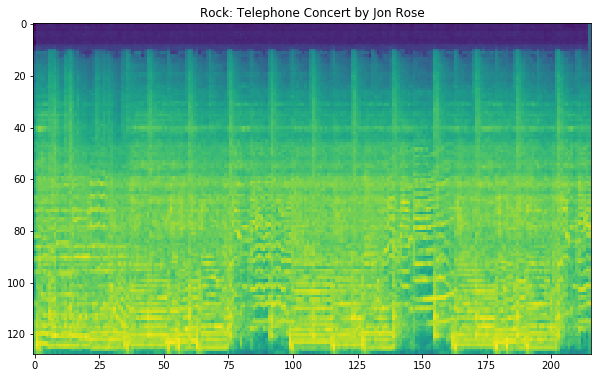

In [313]:
dataset.show(random.choice(range(dataset.__len__())))

In [314]:
dl = DataLoader(dataset, batch_size=4, shuffle=True, num_workers=4)

In [321]:
%%time
next(iter(dl))

Offset past EOF
Offset past EOF
Offset past EOF
Offset past EOF
Offset past EOF
Offset past EOF
Offset past EOF
Offset past EOF
Offset past EOF
Offset past EOF
Offset past EOF
Offset past EOF
Offset past EOF
Offset past EOF
Offset past EOF
Offset past EOF
Offset past EOF
CPU times: user 23.7 ms, sys: 132 ms, total: 156 ms
Wall time: 1.86 s


{'audio': tensor([[[[3.5332e-03, 3.5783e+03, 2.0648e+03,  ..., 2.2861e+03,
            3.0366e+03, 9.9321e+03],
           [1.0420e-02, 1.8314e+04, 1.6880e+04,  ..., 2.0529e+05,
            2.0011e+05, 4.1363e+04],
           [8.8728e-03, 3.2327e+04, 1.1328e+04,  ..., 3.4318e+05,
            5.2874e+05, 5.5776e+04],
           ...,
           [8.9044e-04, 9.3534e-02, 4.0089e-01,  ..., 4.4881e-01,
            8.5282e-01, 3.0014e+01],
           [5.5567e-05, 1.3318e-02, 1.4491e-03,  ..., 2.3286e-03,
            5.3087e-03, 4.5110e-03],
           [5.9858e-05, 1.6391e-02, 1.4310e-03,  ..., 1.4665e-03,
            7.6973e-04, 3.3492e-03]],
 
          [[5.0266e-03, 3.5537e+03, 1.8029e+03,  ..., 2.2168e+03,
            3.1822e+03, 9.5765e+03],
           [1.4424e-02, 1.7589e+04, 1.5898e+04,  ..., 1.9521e+05,
            1.9185e+05, 3.9131e+04],
           [1.1949e-02, 3.0393e+04, 1.0847e+04,  ..., 3.2412e+05,
            5.0709e+05, 5.3768e+04],
           ...,
           [9.2563e-04, 9.415

max(tracks.track_genres.apply(get_genre_id))

In [186]:
def get_genre_id(genre):
    try:
        return int(genre[0]['genre_id'])
    except:
        return 0

In [14]:
genres = pd.read_csv(datap/"fma_meta/genres.csv")

In [15]:
genres.head()

,genre_id,#tracks,parent,title,top_level
0,1,8693,38,Avant-Garde,38
1,2,5271,0,International,2
2,3,1752,0,Blues,3
3,4,4126,0,Jazz,4
4,5,4106,0,Classical,5


In [30]:
genres.genre_id.unique()

array([   1,    2,    3,    4,    5,    6,    7,    8,    9,   10,   11,
         12,   13,   14,   15,   16,   17,   18,   19,   20,   21,   22,
         25,   26,   27,   30,   31,   32,   33,   36,   37,   38,   41,
         42,   43,   45,   46,   47,   49,   53,   58,   63,   64,   65,
         66,   70,   71,   74,   76,   77,   79,   81,   83,   85,   86,
         88,   89,   90,   92,   94,   97,   98,  100,  101,  102,  103,
        107,  109,  111,  113,  117,  118,  125,  130,  137,  138,  166,
        167,  169,  170,  171,  172,  173,  174,  175,  176,  177,  178,
        179,  180,  181,  182,  183,  184,  185,  186,  187,  188,  189,
        214,  224,  232,  236,  240,  247,  250,  267,  286,  296,  297,
        311,  314,  322,  337,  359,  360,  361,  362,  374,  377,  378,
        400,  401,  404,  428,  439,  440,  441,  442,  443,  444,  456,
        465,  468,  491,  493,  495,  502,  504,  514,  524,  538,  539,
        542,  567,  580,  602,  619,  651,  659,  6

In [21]:
genres.parent.unique()

array([  38,    0,   20,   14,    6, 1235,   12,   17,    4,   15,   65,
          2,   45,    9,   25,   10,   92,   21,   53,   31,   26,   13,
         86,    5,  297,  109,   19,  182,  181,   85,  468,  651,   46,
        130,   18,    3,   79,   16,  102,  763])

In [22]:
genres.parent.nunique()

40

In [25]:
genres

,genre_id,#tracks,parent,title,top_level
0,1,8693,38,Avant-Garde,38
1,2,5271,0,International,2
2,3,1752,0,Blues,3
3,4,4126,0,Jazz,4
4,5,4106,0,Classical,5
...,...,...,...,...,...
158,1032,60,102,Turkish,2
159,1060,30,46,Tango,2
160,1156,26,130,Fado,2
161,1193,72,763,Christmas,38


In [88]:
genre_names = {}
for i,gid in enumerate(genres.genre_id):
    genre_names[gid] = genres['title'].iloc[i]
genre_names

{1: 'Avant-Garde',
 2: 'International',
 3: 'Blues',
 4: 'Jazz',
 5: 'Classical',
 6: 'Novelty',
 7: 'Comedy',
 8: 'Old-Time / Historic',
 9: 'Country',
 10: 'Pop',
 11: 'Disco',
 12: 'Rock',
 13: 'Easy Listening',
 14: 'Soul-RnB',
 15: 'Electronic',
 16: 'Sound Effects',
 17: 'Folk',
 18: 'Soundtrack',
 19: 'Funk',
 20: 'Spoken',
 21: 'Hip-Hop',
 22: 'Audio Collage',
 25: 'Punk',
 26: 'Post-Rock',
 27: 'Lo-Fi',
 30: 'Field Recordings',
 31: 'Metal',
 32: 'Noise',
 33: 'Psych-Folk',
 36: 'Krautrock',
 37: 'Jazz: Vocal',
 38: 'Experimental',
 41: 'Electroacoustic',
 42: 'Ambient Electronic',
 43: 'Radio Art',
 45: 'Loud-Rock',
 46: 'Latin America',
 47: 'Drone',
 49: 'Free-Folk',
 53: 'Noise-Rock',
 58: 'Psych-Rock',
 63: 'Bluegrass',
 64: 'Electro-Punk',
 65: 'Radio',
 66: 'Indie-Rock',
 70: 'Industrial',
 71: 'No Wave',
 74: 'Free-Jazz',
 76: 'Experimental Pop',
 77: 'French',
 79: 'Reggae - Dub',
 81: 'Afrobeat',
 83: 'Nerdcore',
 85: 'Garage',
 86: 'Indian',
 88: 'New Wave',
 89: 'P

In [23]:
parent_genre_map = {}
for i,g in enumerate(genres.genre_id):
    parent_genre_map[g] = genres.parent[i]

In [28]:
parent_genre_map[3]

0

In [37]:
tracks = pd.read_csv(datap/"fma_meta/raw_tracks.csv")

In [38]:
tracks

,track_id,album_id,album_title,album_url,artist_id,artist_name,artist_url,artist_website,license_image_file,license_image_file_large,...,track_information,track_instrumental,track_interest,track_language_code,track_listens,track_lyricist,track_number,track_publisher,track_title,track_url
0,2,1.0,AWOL - A Way Of Life,http://freemusicarchive.org/music/AWOL/AWOL_-_...,1,AWOL,http://freemusicarchive.org/music/AWOL/,http://www.AzillionRecords.blogspot.com,http://i.creativecommons.org/l/by-nc-sa/3.0/us...,http://fma-files.s3.amazonaws.com/resources/im...,...,NaN,0,4656,en,1293,NaN,3,NaN,Food,http://freemusicarchive.org/music/AWOL/AWOL_-_...
1,3,1.0,AWOL - A Way Of Life,http://freemusicarchive.org/music/AWOL/AWOL_-_...,1,AWOL,http://freemusicarchive.org/music/AWOL/,http://www.AzillionRecords.blogspot.com,http://i.creativecommons.org/l/by-nc-sa/3.0/us...,http://fma-files.s3.amazonaws.com/resources/im...,...,NaN,0,1470,en,514,NaN,4,NaN,Electric Ave,http://freemusicarchive.org/music/AWOL/AWOL_-_...
2,5,1.0,AWOL - A Way Of Life,http://freemusicarchive.org/music/AWOL/AWOL_-_...,1,AWOL,http://freemusicarchive.org/music/AWOL/,http://www.AzillionRecords.blogspot.com,http://i.creativecommons.org/l/by-nc-sa/3.0/us...,http://fma-files.s3.amazonaws.com/resources/im...,...,NaN,0,1933,en,1151,NaN,6,NaN,This World,http://freemusicarchive.org/music/AWOL/AWOL_-_...
3,10,6.0,Constant Hitmaker,http://freemusicarchive.org/music/Kurt_Vile/Co...,6,Kurt Vile,http://freemusicarchive.org/music/Kurt_Vile/,http://kurtvile.com,http://i.creativecommons.org/l/by-nc-nd/3.0/88...,http://fma-files.s3.amazonaws.com/resources/im...,...,NaN,0,54881,en,50135,NaN,1,NaN,Freeway,http://freemusicarchive.org/music/Kurt_Vile/Co...
4,20,4.0,Niris,http://freemusicarchive.org/music/Chris_and_Ni...,4,Nicky Cook,http://freemusicarchive.org/music/Chris_and_Ni...,NaN,http://i.creativecommons.org/l/by-nc-nd/3.0/88...,http://fma-files.s3.amazonaws.com/resources/im...,...,NaN,0,978,en,361,NaN,3,NaN,Spiritual Level,http://freemusicarchive.org/music/Chris_and_Ni...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
109722,155316,22940.0,"Live at Monty Hall, 2/17/2017",http://freemusicarchive.org/music/Spowder/Live...,24357,Spowder,http://freemusicarchive.org/music/Spowder/,https://spowder.bandcamp.com/,http://i.creativecommons.org/l/by-nc-nd/4.0/88...,http://fma-files.s3.amazonaws.com/resources/im...,...,NaN,0,122,NaN,102,NaN,3,NaN,The Auger,http://freemusicarchive.org/music/Spowder/Live...
109723,155317,22940.0,"Live at Monty Hall, 2/17/2017",http://freemusicarchive.org/music/Spowder/Live...,24357,Spowder,http://freemusicarchive.org/music/Spowder/,https://spowder.bandcamp.com/,http://i.creativecommons.org/l/by-nc-nd/4.0/88...,http://fma-files.s3.amazonaws.com/resources/im...,...,NaN,0,194,NaN,165,NaN,4,NaN,Let's Skin Ruby,http://freemusicarchive.org/music/Spowder/Live...
109724,155318,22940.0,"Live at Monty Hall, 2/17/2017",http://freemusicarchive.org/music/Spowder/Live...,24357,Spowder,http://freemusicarchive.org/music/Spowder/,https://spowder.bandcamp.com/,http://i.creativecommons.org/l/by-nc-nd/4.0/88...,http://fma-files.s3.amazonaws.com/resources/im...,...,NaN,0,214,NaN,168,NaN,6,NaN,My House Smells Like Kim Deal/Pulp,http://freemusicarchive.org/music/Spowder/Live...
109725,155319,22940.0,"Live at Monty Hall, 2/17/2017",http://freemusicarchive.org/music/Spowder/Live...,24357,Spowder,http://freemusicarchive.org/music/Spowder/,https://spowder.bandcamp.com/,http://i.creativecommons.org/l/by-nc-nd/4.0/88...,http://fma-files.s3.amazonaws.com/resources/im...,...,NaN,0,336,NaN,294,NaN,5,NaN,The Man With Two Mouths,http://freemusicarchive.org/music/Spowder/Live...


In [52]:
tracks.track_genres[0]["genre_lid"]

'21'